# Diskless Parcels

For input and output we completely rely on a Redis store running somewhere in the network.

In [1]:
## Run once for setup:
# %pip install redis
# %pip install git+https://github.com/willirath/parcels.git@f2e6c5cd0aeddfc8e74feea1519ef6a70614760d

## Set up diskless input data

We'll store a simple U, V field in a Redis store living in a different service. Then, we'll re-read the data to check if they look the same.

In [2]:
import zarr

In [3]:
uv_store = zarr.storage.RedisStore(prefix="uv_", host="redis_store", port=6379)

uv_store

In [4]:
import numpy as np
import xarray as xr

In [5]:
lon = xr.DataArray(np.linspace(0, 360, 100), dims=("lon", ), name="lon")
lat = xr.DataArray(np.linspace(-90, 90, 100), dims=("lat", ), name="lat")

ds = xr.Dataset(
    dict(
        u=(np.cos(np.deg2rad(2 * lat)).where(~lon.isnull()) ** 2).rename("u"),
        v=(- lat / 180).where(~lon.isnull()).rename("v"),
    ),
    coords={"lon": lon, "lat": lat},
)

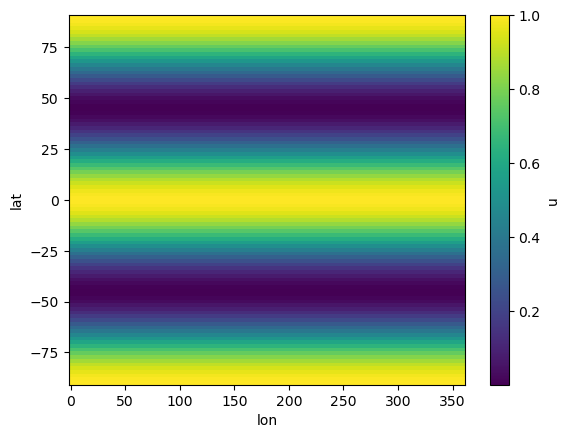

In [6]:
ds.u.plot()

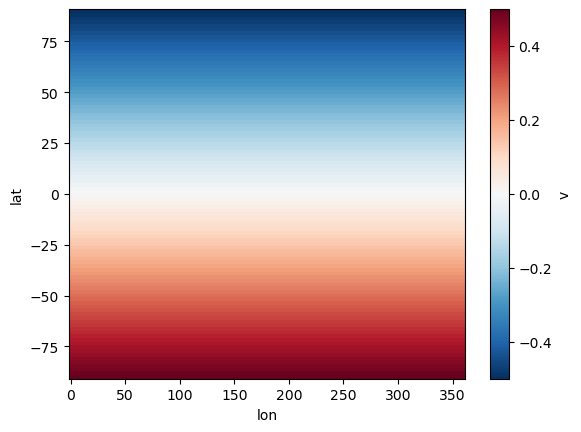

In [7]:
ds.v.plot()

In [8]:
ds.to_zarr(uv_store, mode="w")

In [9]:
ds_reread = xr.open_zarr(uv_store)

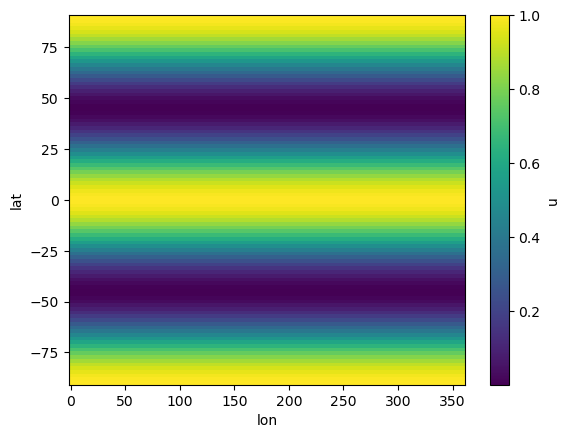

In [10]:
ds_reread.u.plot()

## The Parcels experiment

In [11]:
from parcels import FieldSet, ParticleSet, ScipyParticle, AdvectionRK4, ParticleFile
from parcels.particlefile.baseparticlefile import BaseParticleFile
from datetime import timedelta, datetime

## Fieldset from the Redis store

(So the input data is read from a web service.)

In [12]:
fieldset = FieldSet.from_xarray_dataset(
    xr.open_zarr(uv_store),
    variables={"U": "u", "V": "v"},
    dimensions={"lat": "lat", "lon": "lon"}
)

## A very simple particle set starting in Kiel

In [13]:
pset = ParticleSet.from_list(
    fieldset=fieldset,
    pclass=ScipyParticle,
    lon=np.ones(shape=(100, )) * 10,
    lat=np.linspace(-65, 65, 100),
    time=np.zeros(shape=(100, )),
)

## Streaming _to_ a Redis store

In [14]:
outstore = zarr.storage.RedisStore(prefix="output_", host="redis_store", port=6379)

Note the `ParticleFile` was hacked to not assume what's given as name is a directory name but can be a Zarr store object.

In [15]:
outputfile = pset.ParticleFile(name=outstore, outputdt=timedelta(days=1))

Execute. (Would be interesting to compare timing with local output.)

In [16]:
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=150),
    dt=timedelta(hours=12),
    output_file=outputfile,
)

INFO: Output files are stored in <zarr.storage.RedisStore object at 0x7fe0d7f73f10>.
100%|██████████| 12960000.0/12960000.0 [00:27<00:00, 468875.75it/s] 


## Check outputs

Read from the Redis store. We create a second store object just to make sure there's no hidden caching going on. :)

In [17]:
outstore_opened_again = zarr.storage.RedisStore(prefix="output_", host="redis_store", port=6379)

In [18]:
ds_out = xr.open_zarr(outstore_opened_again)

In [19]:
ds_out

<xarray.Dataset>
Dimensions:     (trajectory: 100, obs: 151)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149 150
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(100, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(100, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(100, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(100, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.0.0b1.dev2864

<AxesSubplot:xlabel='lon', ylabel='lat'>

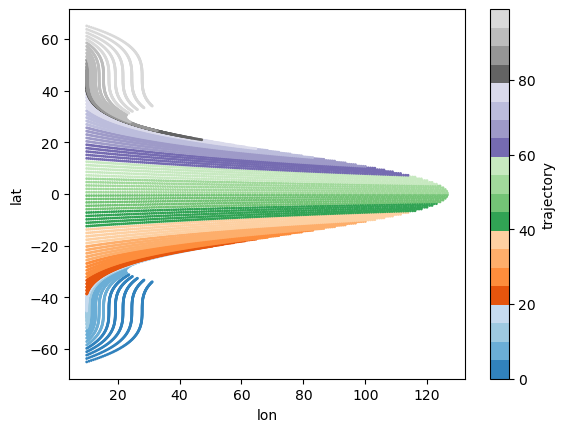

In [20]:
ds_out.to_dataframe().reset_index().plot.scatter(x="lon", y="lat", c="trajectory", s=1, cmap="tab20c")